In [60]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import torch
import math
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
from crp.image import imgify, vis_opaque_img, plot_grid
from torch.optim import SGD, Adam

In [61]:
from expbasics.leemann import disjoint_orthogonality_loss, nearest_neighbors, vis_nearest_neighbors
from expbasics.helper import get_attribution_function, get_model_etc

from expbasics.biased_noisy_dataset import BiasedNoisyDataset

%reload_ext autoreload
%autoreload 2

{0: Counter({False: 164137, True: 81623}), 1: Counter({True: 163542, False: 82218})}


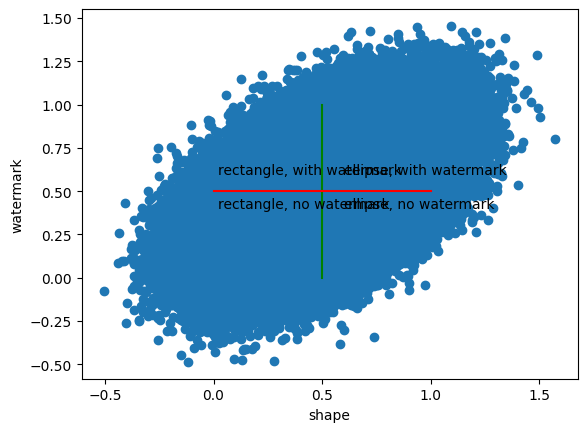

In [71]:
BiasedNoisyDataset(
        verbose=True, bias=0.5, strength=0.5
    )

In [62]:
BIAS = 0.98

model, gm, crp_attribution, unbiased_ds, test_loader = get_model_etc(BIAS)


In [23]:
BATCH_SIZE = 128
N_BASIS = 4
BATCH_STEP_SIZE = 256
NUM_NEIGHBORS = 36
SPATIAL_STEPSIZE = 1

STRENGTH = 0.5
LR = 0.001

LAYER_NAME = "linear_layers.0"#"convolutional_layers.7"


In [63]:
MAX_INDEX = 491520
STEP_SIZE = 1000
single_attr = get_attribution_function(model, heatmap=False, batch_size=1, activations=False)
# cavs_loader = DataLoader(unbiased_ds, batch_size=BATCH_SIZE, shuffle=False)

idx = np.array(list(range(0, MAX_INDEX, STEP_SIZE)))
cavs = torch.zeros((len(idx), 6))
for count, index in enumerate(idx):
    x, _ = unbiased_ds[index]
    res = single_attr(x).detach().contiguous()
    cavs[count] = res

In [65]:
print(cavs)

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000, -0.1375,  0.0000,  0.0000,  0.8625,  0.0000],
        [ 0.0000, -0.1206, -0.0794,  0.0000,  0.8000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])


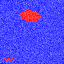

In [12]:
imgify(unbiased_ds[idx[np.random.randint(0, len(idx))]][0])

In [21]:
loss_fn = lambda x: disjoint_orthogonality_loss(
    x, normalize=True, disjoint=True, losstype="offdiagl2"
)
attribution_fn = get_attribution_function(model, heatmap=False, activations=True)


def train_loop(
    model, attribution_fn, loss_fn, n_iter=100, ground_truth_dirs=None, optimize=True
):
    """Main look to recover the matrix M such that the directions fulfill the IMA/DMA criterion.
    Parameters:
        args: Command line arguments
        model: The trained encoder.
        A_init: Intial matrix M at the start of the optimization
        attribution_fn: Function to compute the gradients. Can be used to implement variations
            of the gradient such as integrated or smoothed grad.
        loss_fn: Function that computes the loss
        logger: Custom logger object to log the optimization progress
        n_iter: Number of iterations to perform
        ground_truth_dirs: Ground truth directions if known (required to compute some alignment metrics)
        optimize: True, if A should be optimized, otherwise only the loss and the metrics are computed and logged.
    Returns the matrix with the discovered directions and the average loss
    """
    A_init = torch.randn(4, 6) #eye
    if optimize:
        A = A_init.clone()
        A.requires_grad_(True)

        opt = Adam((A,), lr=LR)
    else:
        A = A_init

    running_loss = 0.0
    cum_loss = 0.0
    with tqdm(total=n_iter, position=0, leave=True) as pbar:
        epoch_sz = len(test_loader)
        for epoch in range(n_iter // epoch_sz + 1):
            for i, data in enumerate(test_loader):
                x, _ = data
                J = attribution_fn(x).detach().contiguous()
                #J = J[:,[1,3,4]]
                J = J.view(J.size(0), J.size(1), -1)  # [B, latent_dim, input_dim]
                disentangledJ = torch.matmul(A.unsqueeze(0), J) #A.unsqueeze(0)
                disentangledJ = disentangledJ.reshape(J.size(0), A.size(0))
                loss = torch.mean(loss_fn(disentangledJ)[1])
                if optimize:
                    loss.backward()
                    opt.step()
                running_loss += loss.detach().item()
                cum_loss += loss.detach().item()
                pbar.update(1)
                if epoch * epoch_sz + i >= n_iter:
                    print("over")
                    break
    return A.detach(), cum_loss / n_iter

H, loss = train_loop(model, attribution_fn, loss_fn)
H, loss

  0%|          | 0/100 [00:00<?, ?it/s]

101it [01:01,  1.64it/s]                         

over


(tensor([[ 0.5595,  0.3596,  0.0751, -1.2765,  0.6859,  0.0389],
         [-0.6610,  1.7669, -1.5960,  0.4026, -0.7006, -0.3537],
         [ 0.4396, -1.4558, -1.8796, -0.0806, -0.8089,  0.9976],
         [ 1.2435,  0.1128, -0.3482,  0.3710,  0.4160,  0.2598]]),
 3.4987425684928892)

In [24]:
nn_idx = nearest_neighbors(H, cavs, idx, NUM_NEIGHBORS, "cosine")  # , "cosine"
for i in range(N_BASIS):
    vis_nearest_neighbors(unbiased_ds, nn_idx[i], f"{LAYER_NAME}_dma_{i}")

In [220]:
def select_max(pred):
    softmax = torch.nn.Softmax(dim=-1)
    id = softmax(pred).argmax(-1).item()
    mask = torch.zeros_like(pred)
    mask[0, id] = pred[0, id]
    # print(mask, mask.shape)
    return mask


sample = unbiased_ds[idx[np.random.randint(0, len(idx))]][0].view(1, 1, 64, 64)
sample.requires_grad = True
crp_attribution.attribution(
    sample,
    [{"linear_layers.0": [0,1,2,3,4,5]}],
    crp_attribution.composite,
    record_layer=crp_attribution.layer_names,
    init_rel=select_max,
)

AttributionResults(heatmap=tensor([[[2.7354e-06, 2.7354e-06, 7.2671e-06,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [2.7354e-06, 2.7354e-06, 7.2671e-06,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [4.8416e-06, 4.8416e-06, 9.7011e-06,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]]]), activations={'convolutional_layers.0': tensor([[[[ 0.0921,  0.0921,  0.0921,  ...,  0.0921,  0.0921,  0.0921],
          [ 0.0921,  0.0921,  0.0921,  ...,  0.0921,  0.0921,  0.0921],
          [ 0.0921,  0.0921,  0.0921,  ...,  0.0921,  0.0921,  0.0921],
          ...,
          [ 0.0921,  0.0921,  0.0921,  ...,  0.0921,  0.0921,  0.0921],
          [ 0.0921, 

In [ ]:
def select_max(pred):
    softmax = torch.nn.Softmax(dim=-1)
    id = softmax(pred).argmax(-1).item()
    mask = torch.zeros_like(pred)
    mask[0, id] = pred[0, id]
    # print(mask, mask.shape)
    return mask


sample = unbiased_ds[idx[np.random.randint(0, len(idx))]][0].view(1, 1, 64, 64)
sample.requires_grad = True
crp_attribution.attribution(
    sample,
    [{"linear_layers.0": [0,1,2,3,4,5]}],
    crp_attribution.composite,
    record_layer=crp_attribution.layer_names,
    init_rel=select_max,
)

AttributionResults(heatmap=tensor([[[2.7354e-06, 2.7354e-06, 7.2671e-06,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [2.7354e-06, 2.7354e-06, 7.2671e-06,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [4.8416e-06, 4.8416e-06, 9.7011e-06,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]]]), activations={'convolutional_layers.0': tensor([[[[ 0.0921,  0.0921,  0.0921,  ...,  0.0921,  0.0921,  0.0921],
          [ 0.0921,  0.0921,  0.0921,  ...,  0.0921,  0.0921,  0.0921],
          [ 0.0921,  0.0921,  0.0921,  ...,  0.0921,  0.0921,  0.0921],
          ...,
          [ 0.0921,  0.0921,  0.0921,  ...,  0.0921,  0.0921,  0.0921],
          [ 0.0921, 

In [118]:
from torch.autograd import grad

crpattr = get_attribution_function(model)

def input_jacobian(net, x):
    """Compute jacobians w.r.t. input. This function is similar to torch.autograd.functional.jacobian
    in later pytorch versions.
    Parameters:
        net: Encoder for which encode_deterministic will be called.
    Return the gradient with respect to each input for each sample.
    """
    x.requires_grad_(True)
    out = net(x)
    J_list = []
    for k in range(net.z_dim):
        J = grad(out[:, k], x, torch.ones_like(out[:, k]), retain_graph=True)[0]
        # print(J.shape)
        J_list.append(J)
    jac = torch.stack(J_list, dim=1)
    return jac


def smoothgrad_gradients(net, x, n_samples=20, noise_lvl=0.02):
    """Return the smoothgrad attributions."""
    noise = noise_lvl * torch.randn(n_samples, *x.shape)
    interps = x.reshape(-1, x.size(0), x.size(1), x.size(2), x.size(3)) + noise
    interps = interps.contiguous()
    old_shape = interps.shape
    # print(interps.shape)
    # flatten inputs to compute model gradients.
    interps = interps.reshape(-1, interps.size(2), interps.size(3), interps.size(4))

    jacs = input_jacobian(net, interps)
    # print(jacs.shape)
    sg = jacs.reshape(
        old_shape[0], old_shape[1], -1, old_shape[2], old_shape[3], old_shape[4]
    ).sum(dim=0)
    return sg

attribution_fn = lambda net, x: smoothgrad_gradients(
    net, x, n_samples=128
)  # get_attribution_function(model)

In [26]:
cond_layer = "linear_layers.0" #"convolutional_layers.6"  # 

t = torch.zeros((N_BASIS, NUM_NEIGHBORS, 64, 64))
told = torch.zeros((N_BASIS, NUM_NEIGHBORS, 64, 64))
for i in range(N_BASIS):
    for index in range(NUM_NEIGHBORS):
        hold, pred = crp_attribution.heatmap(nn_idx[i][index])
        h = crp_attribution.cav_heatmap(nn_idx[i][index], cond_layer, H[i])
        t[i][index] = h
        told[i][index] = hold


def show_neighbors(hms, index):
    return imgify(
        hms[index],
        grid=(
            math.floor(math.sqrt(NUM_NEIGHBORS)),
            math.floor(math.sqrt(NUM_NEIGHBORS)),
        ),
        symmetric =True
    )


def show_all_cavs(hms):
    f, ax = plt.subplots(
        1, N_BASIS, figsize=(20, 12), gridspec_kw={"wspace": 0.1, "hspace": 0}
    )
    for n in range(N_BASIS):
        ax[n].xaxis.set_visible(False)
        ax[n].yaxis.set_visible(False)
        ax[n].imshow(show_neighbors(hms, n))

In [37]:
small_ds = random_split(unbiased_ds)

{'convolutional_layers.0': <crp.concepts.ChannelConcept at 0x7f7520f75210>,
 'convolutional_layers.3': <crp.concepts.ChannelConcept at 0x7f7520f75210>,
 'convolutional_layers.6': <crp.concepts.ChannelConcept at 0x7f7520f75210>,
 'linear_layers.0': <crp.concepts.ChannelConcept at 0x7f7520f75210>,
 'linear_layers.2': <crp.concepts.ChannelConcept at 0x7f7520f75210>}

In [40]:
from crp.visualization import FeatureVisualization

fv = FeatureVisualization(
    crp_attribution.attribution,
    test_loader.dataset,
    {LAYER_NAME: crp_attribution.cc},
    path=crp_attribution.fv_path
)
saved_files = fv.run(
    crp_attribution.composite, 0, len(test_loader.dataset), 128, 2048
)


Running Analysis...



























  5%|▌         | 208/3840 [03:00<52:36,  1.15it/s]





































































































































































































































































































































































100%|██████████| 384/384 [01:07<00:00,  5.72it/s]


100%|██████████| 2/2 [00:00<00:00, 1281.49it/s]


/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/crp/image.py:288: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


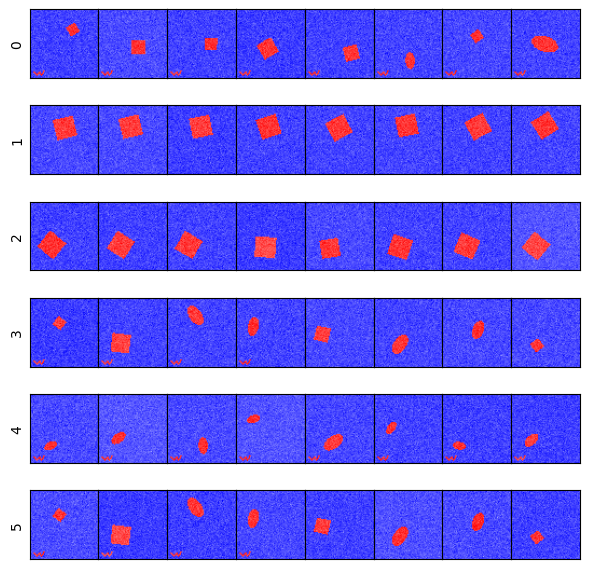

In [56]:
from crp.image import vis_img_heatmap
plot_grid(fv.get_max_reference([0,1,2,3,4,5], LAYER_NAME,rf=False, plot_fn=vis_img_heatmap))

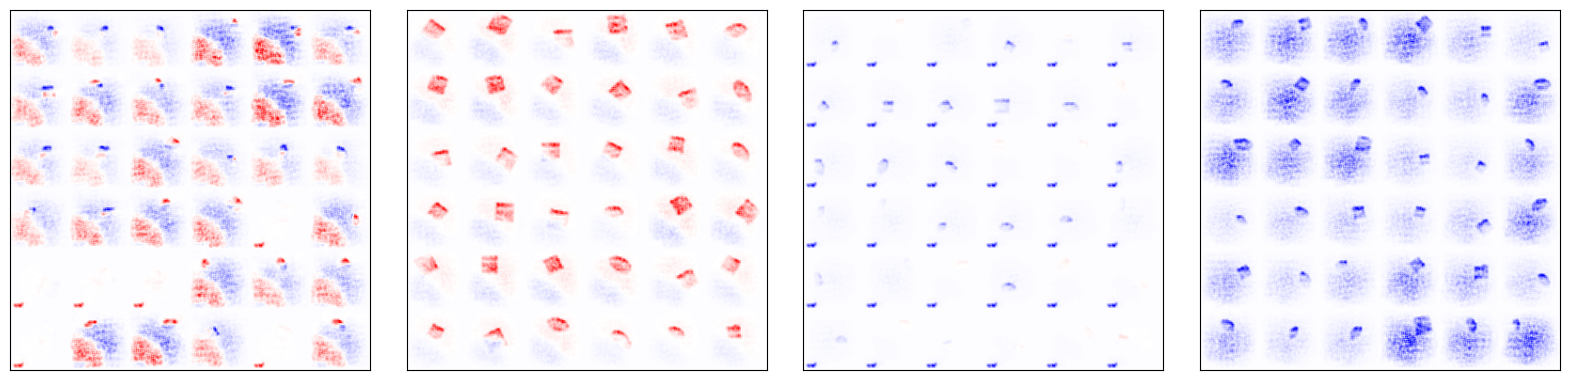

In [27]:
show_all_cavs(t)

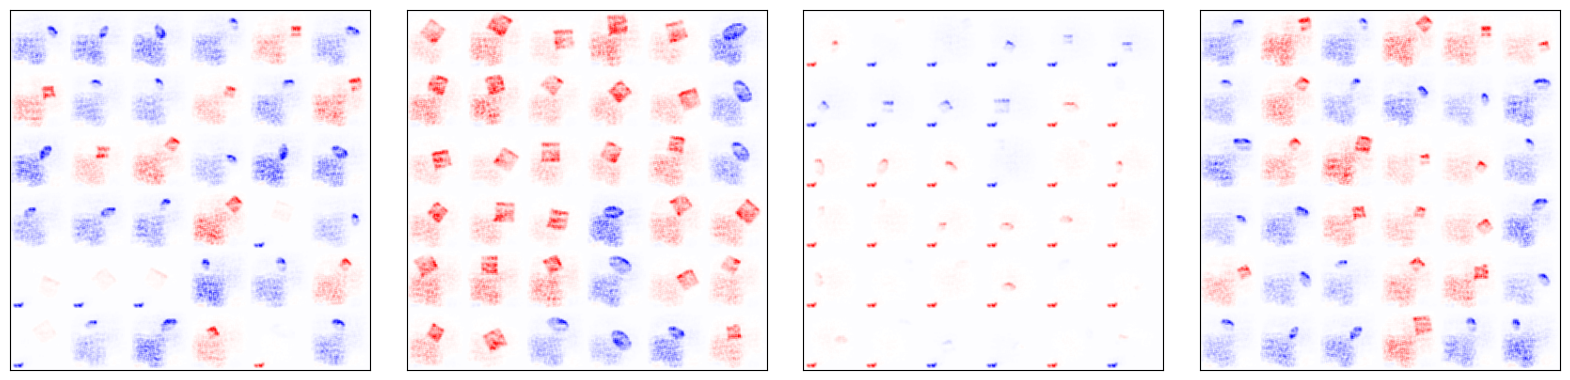

In [28]:
show_all_cavs(told)

In [48]:
H,  [np.intersect1d(nn_idx[x], nn_idx[y]).shape if x != y else "same" for x in range(4) for y in range(4)]


(array([[ 0.        ,  0.        , 11.75612329,  8.71191297, 22.50457525,
          0.        ],
        [ 0.        ,  0.        ,  0.02257934,  0.        ,  0.02345084,
         12.35677329],
        [ 0.        ,  0.        ,  3.80525514,  2.85483271,  4.24792524,
          0.        ],
        [ 0.        ,  0.        ,  4.30456958,  2.68263138,  5.69847257,
          0.        ]]),
 ['same',
  (0,),
  (0,),
  (0,),
  (0,),
  'same',
  (0,),
  (0,),
  (0,),
  (0,),
  'same',
  (0,),
  (0,),
  (0,),
  (0,),
  'same'])

In [29]:
crp_attribution.layer_id_map

{'convolutional_layers.0': array([0, 1, 2, 3, 4, 5, 6, 7]),
 'convolutional_layers.3': array([0, 1, 2, 3, 4, 5, 6, 7]),
 'convolutional_layers.6': array([0, 1, 2, 3, 4, 5, 6, 7]),
 'linear_layers.0': array([0, 1, 2, 3, 4, 5]),
 'linear_layers.2': array([0, 1])}

In [1]:
L1  https://transformer-circuits.pub/2023/monosemantic-features

TCAV -> 

multipliziere activations in latent space mit basisvektoren 
https://arxiv.org/abs/2303.12641

SyntaxError: invalid syntax (911830306.py, line 1)